# Kaggle Competition
## Javier Palomares
Instructions:
This is the in class kaggle competition for Data Mining EE 380L. The data needed is in the Data page and you can view your position on the leaderboard. You will only be able to see your position on the public leaderboard. The public leaderboard uses a subset of the testing data that we give you to rank you. You can see your position here. However, there is also a private leaderboard that uses the remaining data in your test set. Please make sure to not overfit. Hopefully, if you do well in the public leaderboard, you will do well in the private leaderboard, but it is still possible to overfit the public leaderboard. Consider using your own validation schemes to get a sense of your generalization error as well.

The kaggle competition is to be done individually. Please don't collaborate in any way as this is a competition amongst you all. You're ranking on both the public and private leaderboards will be part of your grade for this assignment. There is no other information on the features. Please explore the data to understand the features and decided how you want to proceed. Points will be given for creativity as well so try lots of different things (albeit with adequate justification and explanation for your approaches).

As for your report for the competition, everyone should submit a pdf on Canvas detailing what they tried, why they tried it, what they think worked well and why, what they think didn't work well and why, as well as anything you think which makes your solution particularly creative. Please also include your kaggle username, so we know which score belongs to you, along with your public and private leaderboard score. The report will be due after the competition closes so you can see how you ended up.

## Reading the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

In [2]:
def get_data():
    train = pd.read_csv('./input/train_final.csv')
    test = pd.read_csv('./input/test_final.csv')
    return train,test

In [3]:
train,test = get_data()

In [4]:
train.head()

,Id,Y,f1,f2,f3,f4,f5,f6,f7,f8,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,1,1,25884,1,33.63,118596,1,0,118595,125738,...,1945,118450,119184,1,121372,1,1,1,2,1
1,2,1,34346,1,10.62,118041,1,0,117902,130913,...,15385,117945,292795,1,259173,1,1,1,1,1
2,3,1,34923,1,1.77,118327,1,0,117961,124402,...,7547,118933,290919,1,118784,1,1,1,1,1
3,4,1,80926,1,30.09,118300,1,0,117961,301218,...,4933,118458,118331,1,307024,1,1,1,2,1
4,5,1,4674,1,1.77,119921,1,0,119920,302830,...,13836,142145,4673,1,128230,1,1,1,620,1


In [5]:
train.shape

(16383, 26)

In [6]:
def get_train_test():
    train,test = get_data()
    x_train= train.loc[:,'f1':'f24']
    y = train.Y
    x_test = test.loc[:,'f1':'f24']
    ids = test.Id
    return x_train,y,x_test,ids


In [41]:
x_train,y,x_test,ids = get_train_test()

In [88]:
x_train= train.loc[:,'f1':'f24']
features = x_train.columns
x_train.shape

(16383, 24)

(array([6.456e+03, 5.296e+03, 4.141e+03, 3.760e+02, 0.000e+00, 0.000e+00,
        8.000e+00, 1.000e+00, 8.000e+01, 2.500e+01]),
 array([-1.000000e+00,  3.121430e+04,  6.242960e+04,  9.364490e+04,
         1.248602e+05,  1.560755e+05,  1.872908e+05,  2.185061e+05,
         2.497214e+05,  2.809367e+05,  3.121520e+05]),
 <a list of 10 Patch objects>)

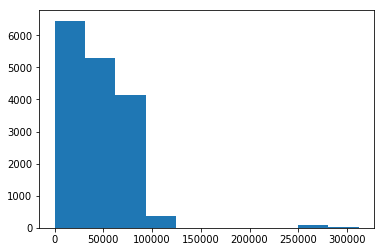

In [19]:
plt.hist(x_train.f1)

In [20]:
x_train.f1.min()

-1

(array([  948.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15435.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

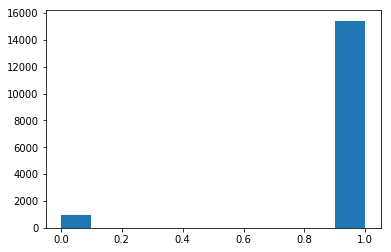

In [21]:
plt.hist(y)

It looks like the y variable is binary classification variable

## Data Preprocessing

In [37]:
def get_numerical_features(x):
    numeric_feats = x.dtypes[x.dtypes != "object"].index
    return numeric_feats
# take the log of skewed features in the testing and training data
def log_norm_skewd_feats(skew_factor,x_train,x_test):
    numeric_feats = get_numerical_features(x_train)
    skewedness_factor = x_train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewedness_factor[skewedness_factor > skew_factor].index
    #f1 has a negative value, don't log transform f1
    skewed_feats = skewed_feats.delete(0)
    # take the log of skewed features
    x_train[skewed_feats] = np.log1p(x_train[skewed_feats])
    x_test[skewed_feats] = np.log1p(x_test[skewed_feats])
    return x_train,x_test

def fill_nas_with_mean(x):
    x = x.fillna(x.mean())
    return x

def get_binary_cols(df):
    bin_cols = [col for col in df if 
               df[col].dropna().value_counts().index.isin([0,1]).all()]
    return bin_cols
def gauss_norm_data(x_train,x_test):
    mu = np.mean(x_train,axis = 0)
    sigma = np.std(x_train,axis=0)
    x_train = (x_train - mu)/ sigma
    x_test = (x_test - mu) / sigma
    return x_train,x_test


In [28]:
numeric_feats = get_numerical_features(x_train)
print(numeric_feats)

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11',
       'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21',
       'f22', 'f23', 'f24'],
      dtype='object')


All features are numeric.

In [37]:
bin_cols = get_binary_cols(x_train)
print(bin_cols)

[]


There's no binary columns (other than the y column)

## Models

### Logistic Regresssion

I'll first try fitting a logistic regression classifier with no pre-processing

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn import metrics
import datetime

In [10]:
# function to compute the auc score
def auc_score(y_pred_proba,y):
    return metrics.roc_auc_score(y,y_pred_proba)
def write_predictions(filename,header,ids,y_pred):
    f = open(filename,'w')
    numRows = len(ids)
    f.write(header)
    for i in range(numRows):
        idNum = ids[i]
        y = y_pred[i]
        f.write("{},{}\n".format(idNum,y))
    f.close()
def get_prediction_proba(model,x_train,x_test):
    y_train_proba = model.predict_proba(x_train)[:,1]
    y_test_proba = model.predict_proba(x_test)[:,1]
    return y_train_proba,y_test_proba
    
    

In [46]:
x_train,y,x_test,ids = get_train_test()
n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas).tolist()
model_logistic = LogisticRegressionCV(Cs=alphas,cv=10,solver='liblinear').fit(x_train,y)

In [52]:
# get the predictions from the model
y_train_proba,y_test_proba = get_prediction_proba(model_logistic,x_train,x_test)

In [53]:
auc_score(y_train_proba,y)

0.5325772704098718

In [70]:
write_predictions("predictions/logistic_regression_"+datetime.datetime.now().isoformat() + ".csv","Id,Y\n",ids,y_test_proba)

With no pre processing, the auc score was 0.5325772704098718.


Next I'll try taking log normalizing skewed columns and filling NA's with the mean

In [62]:
x_train,y,x_test,ids = get_train_test()
x_train = fill_nas_with_mean(x_train)
x_train,x_test= log_norm_skewd_feats(.75,x_train,x_test)

Train the classifier on the log normalized data

In [63]:
model_logistic_preproc = LogisticRegressionCV(Cs=alphas,cv=10,solver='liblinear').fit(x_train,y)

get the predictions from this logistic regression

In [66]:
y_train_preproc_proba,y_test_preproc_proba = get_prediction_proba(model_logistic_preproc,x_train,x_test)

In [67]:
auc_score(y_train_preproc_proba,y)

0.5048381056260157

In [76]:
write_predictions("predictions/logistic_regression_preproc_"+datetime.datetime.now().isoformat() + ".csv","Id,Y\n",ids,y_test_preproc_proba)

The auc score actually got worse with log normalization.
I will try standardizing data to a gaussian instead

In [75]:
len(ids)

16385

In [77]:
x_train,y,x_test,ids = get_train_test()
x_train = fill_nas_with_mean(x_train)
x_train,x_test = gauss_norm_data(x_train,x_test)

In [78]:

model_logistic_norm = LogisticRegressionCV(Cs=alphas,cv=10,solver='liblinear').fit(x_train,y)

In [83]:
y_train_pred_norm,y_test_pred_norm = get_prediction_proba(model_logistic_norm,x_train,x_test)   


In [84]:
auc_score(y_train_pred_norm,y)

0.5702679946802913

Score did improve after normalizing to 0.5702679946802913

In [85]:
write_predictions("predictions/logistic_regression_norm_"+datetime.datetime.now().isoformat() + ".csv","Id,Y\n",ids,y_test_pred_norm)

### XGBoost

Next I'll try using XGBoost Classifier

In [38]:
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [39]:
x_train,y,x_test,ids = get_train_test()
model = XGBClassifier()
model.fit(x_train,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [40]:
y_train_xgboost,y_test_xgboost = get_prediction_proba(model,x_train,x_test)

In [41]:
auc_score(y_train_xgboost,y)

0.9057251451916913

In [92]:
write_predictions("predictions/xgboost_"+datetime.datetime.now().isoformat() + ".csv","Id,Y\n",ids,y_test_pred_norm)


xgboost scored much better. I'll try xgboost with gaussian normalization preprocessing

In [42]:
x_train,y,x_test,ids = get_train_test()
x_train = fill_nas_with_mean(x_train)
x_train,x_test = gauss_norm_data(x_train,x_test)
model_xg_boost_norm = XGBClassifier()
model_xg_boost_norm.fit(x_train,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [43]:
y_train_norm_xgboost,y_test_norm_xgboost = get_prediction_proba(model_xg_boost_norm,x_train,x_test)


In [44]:
auc_score(y_train_norm_xgboost,y)

0.9057251451916913

Didn't really see an improvement in the auc score or when submitting the predictions

In [99]:
write_predictions("predictions/xgboost_norm_"+datetime.datetime.now().isoformat() + ".csv","Id,Y\n",ids,y_test_norm_xgboost)


Next I'll try optimizing the hyper parameters of xgboost

In [45]:
x_train,y,x_test,ids = get_train_test()
clf = xgb.XGBClassifier(
                max_depth = 7,
                n_estimators=700,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                seed=1301,
                objective='binary:logistic',
                eval_metric='auc')
clf.fit(x_train,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=3, missing=None,
       n_estimators=700, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1301, silent=True, subsample=1.0)

In [46]:
y_train,y_test = get_prediction_proba(clf,x_train,x_test)

In [47]:
auc_score(y_train,y)

0.9999991799010141

In [20]:
write_predictions("predictions/xgboost_"+datetime.datetime.now().isoformat() + ".csv","Id,Y\n",ids,y_test)


This prediction had a score of 0.88843! Nice! 

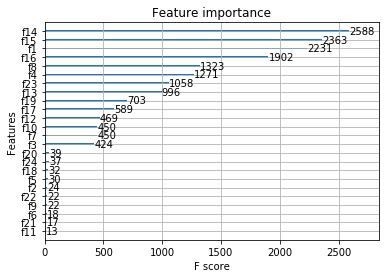

In [56]:
xgb.plot_importance(clf)

In [80]:
np.sort(clf.feature_importances_)

array([0.00076153, 0.00099584, 0.00105442, 0.00128874, 0.00128874,
       0.00140589, 0.00175737, 0.00187452, 0.00216742, 0.00228458,
       0.02483744, 0.0263605 , 0.0263605 , 0.02747349, 0.03450296,
       0.04118095, 0.05834456, 0.06197645, 0.07445375, 0.07749985,
       0.11141703, 0.13068947, 0.13842188, 0.15160213], dtype=float32)

It looks like some features are much more important than others. I'll try to throw away the less important features

In [82]:
from sklearn.feature_selection import SelectFromModel
f_score_thresh = 0.01
selection = SelectFromModel(clf,threshold=f_score_thresh,prefit=True)
x_train,y,x_test,ids = get_train_test()
x_train = fill_nas_with_mean(x_train)
x_train,x_test = gauss_norm_data(x_train,x_test)
selection_x_train = selection.transform(x_train)
selection_x_train.shape

(16383, 14)

The data now only has 14 columns. 
Now train a model with the selected features

In [83]:
clf_selected = xgb.XGBClassifier(
                max_depth = 7,
                n_estimators=700,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                seed=1301,
                objective='binary:logistic',
                eval_metric='auc')

In [84]:
clf_selected.fit(selection_x_train,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eval_metric='auc', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=3, missing=None,
       n_estimators=700, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1301, silent=True, subsample=1.0)

In [85]:
selection_x_test = selection.transform(x_test)
y_train_selected,y_test = get_prediction_proba(clf_selected,selection_x_train,selection_x_test)
auc_score(y_train_selected,y)

0.999996172871399

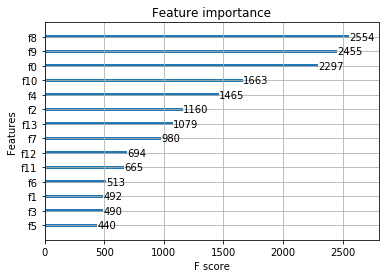

In [86]:
xgb.plot_importance(clf_selected)

In [87]:
write_predictions("predictions/xgboost_selected_"+datetime.datetime.now().isoformat() + ".csv","Id,Y\n",ids,y_test)


This had a score of .88643, not a improvement